<h1> Final assignment description </h1>

The objective is to classify three different classes of ECG signals.
-<h4> Normal sinus rythm; </h4> 
![Normal sinus rythm](img/normal.PNG)
-<h4> Premature ventricular complex (PVC); </h4> 
![PAC](img/pvc.PNG)
-<h4> Premature atrial complex (PAC); </h4> 
![PVC](img/pac.PNG)


We must classify each beat of the signal and each beat of the training set is labelled with:
- N: normal sinus rythm; <br>
- S: supraventricular beats (PAC); <br>
- V: ventricular beats (PVC); <br>

<h2>Dataset </h2>

- 105 patients;
- fs: 128 or 250 Hz;
- 2 leads ECG -> 2 ecg signal for each patient; 
- Rpeaks are annotated in the dedicated .mat file;

File format: 
- [PatientID]\_[fs]+".mat" $\rightarrow$ 2 leads ECG signal;
- [PatientID]\_[fs]+\_[ann]+".mat" $\rightarrow$ labelling of the Rpeaks;
- [PatientID]\_[fs]+\_[rpk]+".mat" $\rightarrow$ Rpeaks location in the signal (at which time an Rpeak appears);

In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image

In [2]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

<h2>Load the dataset</h2>

In [3]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal


labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

<h2>Data visualization</h2>

In [4]:

def plot_signal(sigID,length):
    
    signal = ecg_signals[sigID]

    x = np.arange(length)
    y = signal[:length,0]
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=2.0)

    # we are plotting only the defined time, so we must count how many peaks 
    peak_counter = 0
    
    for peak in rpeaks[sigID][:,0]:
        if (peak > length):
            break
        peak_counter += 1
    
    x = rpeaks[sigID][:peak_counter,0]  # time values of the peaks in between the defined length 
    y = ecg_signals[sigID][x,0]         # amplitude value of the peaks 
    
    ax.scatter(x,y,color = "red")

    peaks_labels = labels[sigID][:peak_counter] 
    offset = 20
    for i,label in enumerate(peaks_labels):
        ax.annotate(label,(x[i]-offset,y[i]),fontsize = "large")

    plt.show()
    

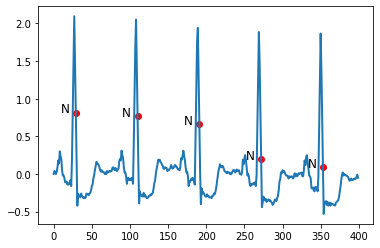

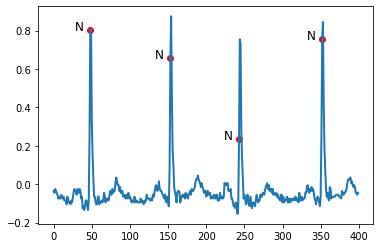

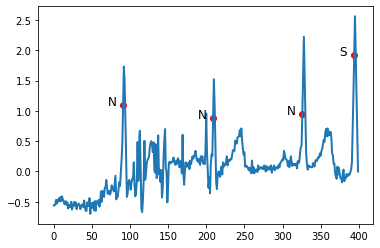

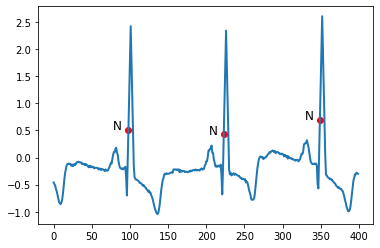

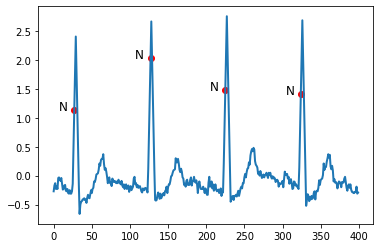

In [5]:
# plot first 5 signals 
for i in range(5):
    plot_signal(i,400)


In [6]:
# this function creates a patch for the defined signal & peak and save it in the "dataset_folder/Patches" folder 
# under the name of [SIGNAL_ID]_[peakID]_[LABEL].png

# there is a problem: sopraventricular beats (PAC complex) are hard to distinguish from the normal sinus beat
def create_patch(sigID,peakID):
    
    signal = ecg_signals[sigID]

    prev = rpeaks[sigID][peakID-1]
    peak = rpeaks[sigID][peakID]
    succ = rpeaks[sigID][peakID+1] 
    x = np.arange(int((peak+prev)/2),int((peak+succ)/2)) # lowest x is equal to the average between the peakID and the previous, dual for the highest x 
    y = signal[x,0]
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=2.0)
    
    plt.axis('off')         # axes are useless in input to the model 
    plt.savefig(dataset_folder+"//Patches//"+str(ids[sigID])+"_"+str(peakID)+"_"+labels[sigID][peakID]+".png",format="png",facecolor = "white",bbox_inches='tight',pad_inches = 0) # save the image 
   

    

In [7]:
# find a peak of a particular class 

v_index = 0
sigID = 0

for i,label in enumerate(labels):
    res = np.where(label == "V")
    if (len(res) != 0):
        sigID = i
        v_index = res[0][0] # TODO: adjust shapes, this is not clean 
        break

print(f"Signal: {sigID}")
print(f"Peak V: {v_index}")

Signal: 0
Peak V: 17


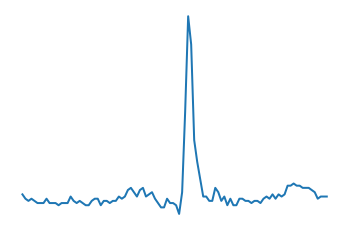

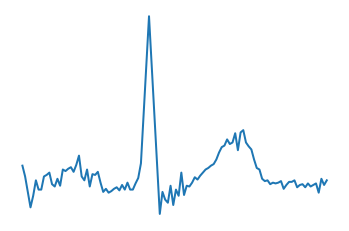

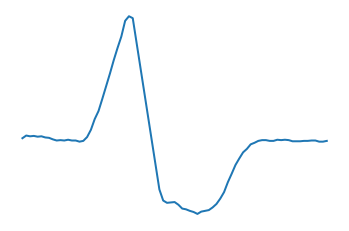

In [8]:
# peak 500 of 3rd patient is a supraventricular one 

create_patch(1,500) # normal N
create_patch(2,500) # supraventricular S 
create_patch(0,17)  # ventricular V


<h2> Problem: Class imbalance </h2>
This must be addressed in a proper way.

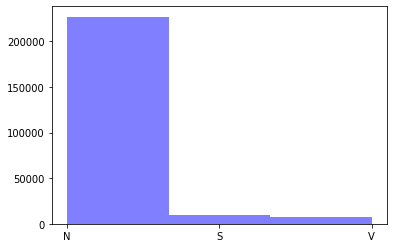

[226932, 9609, 7795]


In [13]:
def count_classes(labels,classes):
    
    counts = [0]*len(classes)

    for i,k in enumerate(classes): # iterate over the classes is not the most efficient one, but it's more readable at the end 
        for label in labels:
            counts[i] += len(np.where(label == k)[0])

    return counts

classes = ["N","S","V"]

x = list()
counts = count_classes(labels,classes)

for i,k in enumerate(classes):
    x.extend([k]*counts[i])

num_bins = len(classes)
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()
print(counts)


In [40]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(np.transpose(signal[:,0]))
    second_lead_signals.append(np.transpose(signal[:,1]))



# labels = list()             # labels 
# ids = list()                # Id of samples 
# rpeaks = list()             # detected peaks of the signal 
# ecg_signals = list()        # .mat ecg signal 
# frequencies = list()        # sample frequency of the ecg signal 

df = pd.DataFrame(data = np.transpose([ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]),columns = cols)
df

C:\Users\simon\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[[29], [110], [191], [272], [353], [433], [514...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[[48], [153], [243], [352], [440], [547], [636...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[[91], [209], [326], [394], [537], [653], [745...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[[98], [223], [349], [474], [599], [726], [853...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[[27], [127], [225], [324], [423], [523], [623...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -...","[[155], [383], [611], [835], [1053], [1275], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2...","[[215], [437], [667], [823], [1119], [1349], [...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -...","[[255], [535], [817], [1093], [1377], [1657], ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17...","[[19], [295], [575], [863], [1151], [1435], [1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [58]:
# dataset needs to be created because we need to classify beats and not the entire signal 

classes = np.array(["N","S","V"])

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.int32)



dataset = dict()
length = 170

for l,id in enumerate(ids):
    for i,peak in enumerate(rpeaks):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()
        p = peak[0]

        for s in range(int(p-length/2),int(p+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["label"] = convert_to_one_hot(labels[l][i])

dataset_df = pd.DataFrame.from_dict(dataset,orient="index")

dataset_df

,first_lead,second_lead,label
S001_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0]"
S001_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0]"
S001_2,"[0.18, 0.14, 0.3, 0.24, 0.2, 0.05, -0.02, -0.0...","[0.18, 0.14, 0.3, 0.24, 0.2, 0.05, -0.02, -0.0...","[1, 0, 0]"
S001_3,"[-0.02, -0.05, -0.11, -0.11, -0.1, -0.14, -0.1...","[-0.02, -0.05, -0.11, -0.11, -0.1, -0.14, -0.1...","[1, 0, 0]"
S001_4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0]"
...,...,...,...
S118_100,"[-0.01, -0.01, -0.01, -0.01, -0.01, -0.015, -0...","[-0.01, -0.01, -0.01, -0.01, -0.01, -0.015, -0...","[1, 0, 0]"
S118_101,"[-0.095, -0.09, -0.085, -0.08, -0.05, -0.03, -...","[-0.095, -0.09, -0.085, -0.08, -0.05, -0.03, -...","[1, 0, 0]"
S118_102,"[0.32, 0.365, 0.405, 0.42, 0.42, 0.365, 0.305,...","[0.32, 0.365, 0.405, 0.42, 0.42, 0.365, 0.305,...","[1, 0, 0]"
S118_103,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0]"


In [70]:
# TRAIN ARRAYS

x_train_ = dataset_df[['first_lead','second_lead']].values 
y_train = dataset_df['label'].values
x_train = list()

for x in x_train_:
    x_train.append(x[0] + x[1])



In [72]:
import keras
import tensorflow as tf 

print(len(x_train[0])

def neuralNet():
    return keras.Sequential([
    keras.layers.Input(shape = (len(x_train[0]),)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(3,activation=tf.nn.softmax)
])

nn = neuralNet()
nn.summary()

learning_rate = 0.0025
nn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy','loss']
)

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = 32,
    #validation_data=(x_valid, y_valid),
    epochs = 10
).history

#validation_data=(X_val_filt, y_val),

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               87296     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 153,859
Trainable params: 153,859
Non-trainable params: 0
_________________________________________________________________


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'numpy.float64\'>", "<class \'float\'>"})', '(<class \'list\'> containing values of types {"<class \'numpy.float64\'>"})'}), <class 'numpy.ndarray'>